In [1]:
#!pip install -q malariagen_data
#!pip install -q scikit-allel
#!pip install -q petl
#!pip install -q fontstyle
#!pip install -q pomegranate

In [1]:
#### import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar
import statistics as stat
import petl

In [2]:
import random
import itertools
#import plotly
import plotly.express as px

In [20]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib_venn as venn
import seaborn as sns
%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [4]:
plt.rcdefaults()
sns.reset_defaults()
rcParams = plt.rcParams
base_font_size = 12
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size
rcParams['legend.fontsize'] = 11
rcParams['axes.linewidth'] = .5
rcParams['lines.linewidth'] = .5
rcParams['patch.linewidth'] = .5
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
#rcParams['savefig.jpeg_quality'] = 100
rcParams['lines.markeredgewidth'] = .5
rcParams['figure.max_open_warning'] = 1000
rcParams['figure.facecolor'] = 'w'

In [5]:
#Mounting Google Drive
#import os
#from google.colab import drive
#drive.mount("drive")

# make dir
#results_dir = "drive/MyDrive/Genomic/"
#os.makedirs(results_dir, exist_ok=True)

In [6]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
#ag3

#samples sets
sets = ["AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C","1191-VO-MULTI-OLOUGHLIN-VMF00106",
        "1191-VO-MULTI-OLOUGHLIN-VMF00140", "1314-VO-BF-KIENTEGA-KIMA-BF-2104"]
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")
bf_samples = df_samples.query('country == "Burkina Faso"')

# Genetic diversity

In [7]:
def fig_diversity(x, h, err, cp=3, ylim=(0,0.03), ax=None, color='red', title=None, xtick_lab=None,
                  bottom=False, top = True, xlab=None, ylab=None, fig_name=None, side=None):
  #define ax
  if ax is None:
    fig, ax = plt.subplots()
    sns.despine(ax=ax, bottom=bottom, top = top, offset=5)

  #plot
  ax.bar(x=x,height=h, yerr=err, color=color,capsize=cp)

   # Plot title
  if title:
    ax.set_title(f'{title}')

  # Customize plot
  if ylab:
    ax.set_ylabel(f'{ylab}')
  if xlab:
    ax.set_xlabel(f'{xlab}')

  #ax setting
  ax.set_ylim(*ylim)
  if top is True:
    if xtick_lab:
      ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
    else:
      plt.xticks(rotation=30, ha='right')
  else:
    if xtick_lab:
      ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='left')
    else:
      plt.xticks(rotation=30, ha='left')

  if fig_name:
    fig.savefig(f"graph/div_{fig_name}.png", dpi=300, bbox_inches='tight', transparent=False)

# Load data - genetic diversity

In [8]:
## compute div data
#dsx_stats = ag3.diversity_stats(sample_query="country == 'Burkina Faso'",
#                                cohorts="admin2_year",
#                                cohort_size=10,
#                                region="AGAP004050",
#                                site_mask="gamb_colu_arab",
#                                site_class="CDS_DEG_4",
#                                sample_sets=sets
#                                )

# Save data
#dsx_stats.to_csv('drive/MyDrive/data_dsx/data_saved/dsx_stats.csv')

In [9]:
#load data diversity data
dsx_stats = pd.read_csv('data_saved/dsx_stats.csv')
pop = 'An_'+dsx_stats['taxon']+'_'+dsx_stats['year'].astype(str)
dsx_stats.insert(2, 'populations', pop)
dsx_stats = dsx_stats.iloc[1:,].drop(dsx_stats.iloc[1:,].columns[0], axis=1).sort_values('populations')
#dsx_stats

In [10]:
col= ['#929591', '#929591', '#929591', '#929591',
      '#029386', '#029386','#029386','#029386','#029386','#029386','#029386',
      '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6','#7BC8F6', '#7BC8F6']
col1= ['#929591', '#929591', '#929591',  '#929591',
       '#D2691E', '#D2691E','#D2691E','#D2691E','#D2691E','#D2691E','#D2691E',
      '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6']

In [11]:
xtick_lab = ['2014', '2015', '2016', '2019', '2012', '2014', '2015', '2016', '2017', '2018', '2019',
             '2012', '2014', '2015', '2016', '2017', '2018', '2019']
label_sp = ['An. arabiensis', 'An. coluzzii', 'An. gambiae s.s.']

In [12]:
#dsx_stats.populations

C:\Users\hp\AppData\Local\Temp\ipykernel_19236\3667566254.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')


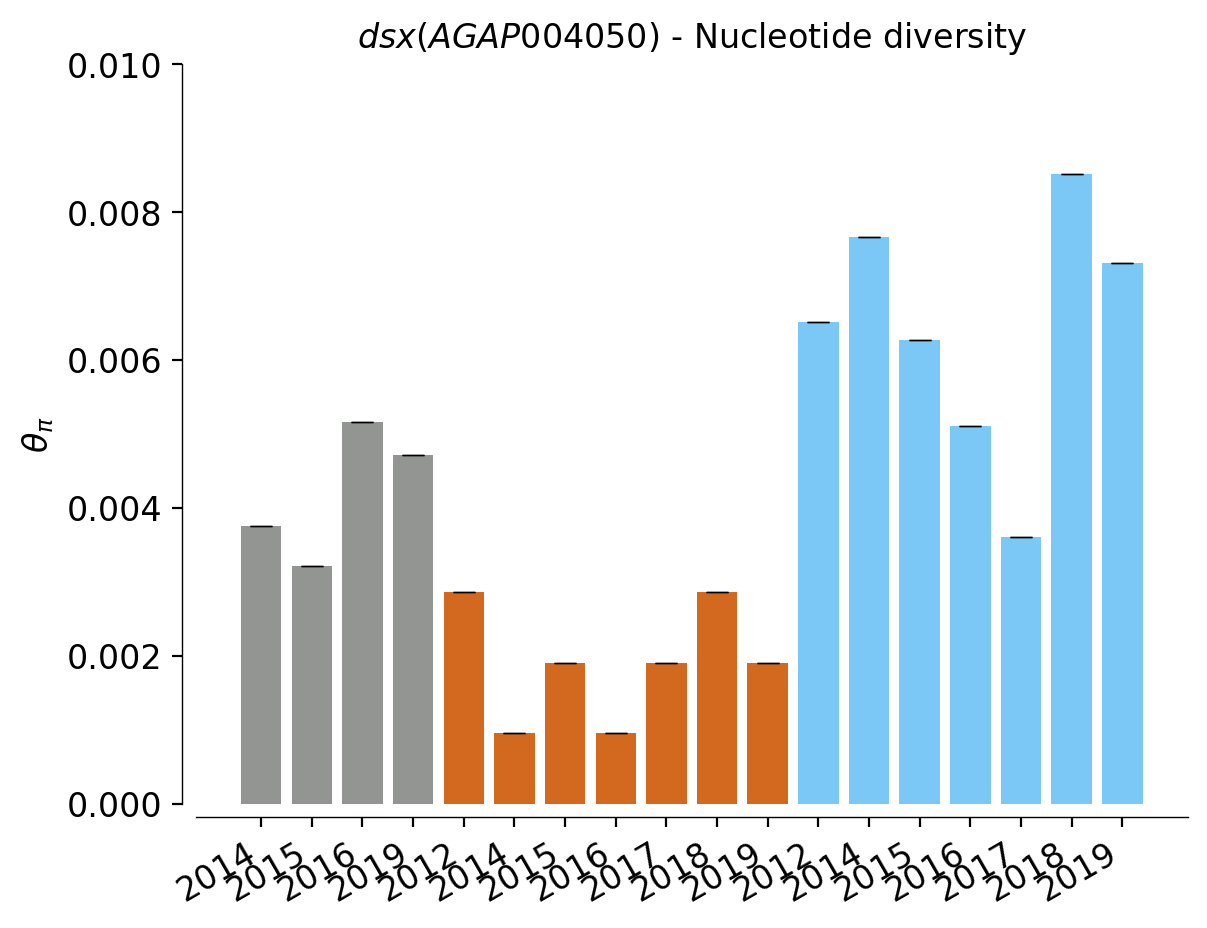

In [22]:
## Plotting - pi
fig_diversity(x=dsx_stats.populations, h=dsx_stats.theta_pi_estimate, err=dsx_stats.theta_pi_ci_err,
              cp=4, title='$dsx (AGAP004050)$ - Nucleotide diversity', ylim=(0,0.01), color=col1,
              xtick_lab=xtick_lab, ylab=r'$\theta_{\pi}$', fig_name=None)
plt.show()

In [14]:
## Plotting - D
fig_diversity(x=dsx_stats.populations, h=dsx_stats.tajima_d_estimate, err=dsx_stats.tajima_d_ci_err,
              cp=4, ylim=(-2, 0), color=col1, ylab=r"$Tajima's$ $D$", bottom=True, top = False, fig_name=None,
              xtick_lab=xtick_lab)
plt.title("$dsx (AGAP004050)$ - Tajima's D", y=-0.03)

C:\Users\hp\AppData\Local\Temp\ipykernel_19236\3667566254.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='left')


Text(0.5, -0.03, "$dsx (AGAP004050)$ - Tajima's D")

In [15]:
## Plotting - w
fig_diversity(x=dsx_stats.populations, h=dsx_stats.theta_w_estimate, err=dsx_stats.theta_w_ci_err,
              cp=4, title='$dsx (AGAP004050)$ - Watterson theta',ylim=(0,0.018), color=col1,
              ylab=r'$\theta_w$', xtick_lab=xtick_lab, fig_name=None)

cmap = dict(zip(label_sp, ['#929591', '#D2691E', '#7BC8F6']))

patches = [Patch(color=v, label=k) for k, v in cmap.items()]

plt.legend(title=' ', labels=label_sp, handles=patches, bbox_to_anchor=(0.15, -0.21), loc='center left',
           borderaxespad=0, ncol=len(label_sp), frameon=False, prop={'size': 10, 'style': 'italic'})


C:\Users\hp\AppData\Local\Temp\ipykernel_19236\3667566254.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')


In [16]:
## fig params
base_font_size = 8
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size

# fig
fig, ax = plt.subplots(figsize=(16,7))
gs = GridSpec(2, 3, hspace = 0.5, wspace=0.30, figure=fig)

ax0 = plt.subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5)
fig_diversity(x=dsx_stats.populations, h=dsx_stats.theta_pi_estimate, err=dsx_stats.theta_pi_ci_err,
              ax=ax0, cp=4, ylim=(0,0.01), xtick_lab=xtick_lab, color=col1, ylab=r'$\theta_{\pi}$',
              fig_name=None)
ax0.text(-0.019, 1.05, 'A', transform=ax.transAxes, size=14,
         bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax1 = plt.subplot(gs[0, 1])
sns.despine(ax=ax1, offset=5)
fig_diversity(x=dsx_stats.populations, h=dsx_stats.theta_w_estimate, err=dsx_stats.theta_w_ci_err,
              ax=ax1, cp=4, ylim=(0,0.020),xtick_lab=xtick_lab, color=col1, ylab=r'$\theta_w$', fig_name=None)
ax1.text(0.34, 1.05, 'B', transform=ax.transAxes, size=14,
         bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax2 = plt.subplot(gs[0, 2])
sns.despine(ax=ax2, bottom=True, top = False, offset=5)
fig_diversity(x=dsx_stats.populations, h=dsx_stats.tajima_d_estimate, err=dsx_stats.tajima_d_ci_err,
              cp=4, ylim=(-2, 0), xtick_lab=xtick_lab, color=col1, ylab=r"$Tajima's$ $D$", ax=ax2,
              bottom=True, top = False, fig_name=None)
ax2.text(0.70, 1.05, 'C', transform=ax.transAxes, size=14,
         bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

## set legend
cmap = dict(zip(label_sp, ['#929591', '#D2691E', '#7BC8F6']))

patches = [Patch(color=v, label=k) for k, v in cmap.items()]

fig.legend(title=' ', labels=label_sp, handles=patches, bbox_to_anchor=(0.5, 0.42), loc='lower center',
           ncol=len(label_sp), frameon=False, prop={'size': 10, 'style': 'italic'})

fig.savefig("graph/dsx_diversity.png", dpi=300, bbox_inches='tight', transparent=False)


C:\Users\hp\AppData\Local\Temp\ipykernel_19236\1260732373.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])
C:\Users\hp\AppData\Local\Temp\ipykernel_19236\3667566254.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
C:\Users\hp\AppData\Local\Temp\ipykernel_19236\3667566254.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='left')


# SNP frequencies - per pop, year, countries

In [17]:
base_font_size = 12
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size

In [82]:
## Load data
## pop
freq_pop = pd.read_csv('data_saved/freq_pop.csv')
freq_pop = freq_pop.drop(freq_pop.columns[0], axis=1)
freq_pop_arr = freq_pop.query('position > 48714420 and position < 48714720')
freq_pop_gd = freq_pop.query('position > 48714637 and position < 48714660')

## freq year
freq_year = pd.read_csv('data_saved/freq_y.csv')
freq_year = freq_year.drop(freq_year.columns[0], axis=1)
Ns_freq = freq_year.query('effect=="NON_SYNONYMOUS_CODING"')
freq_year_arr = freq_year.query('position > 48714420 and position < 48714720')
freq_year_gd = freq_year.query('position > 48714637 and position < 48714660')

## freq countries 
freq_country = pd.read_csv('data_saved/freq_all.csv', low_memory=False)
freq_country = freq_country.drop(freq_country.columns[0], axis=1)
Ns_freq_country = freq_country.query('effect=="NON_SYNONYMOUS_CODING"')
freq_country_arr = freq_country.query('position > 48714420 and position < 48714720')
freq_country_gd = freq_country.query('position > 48714637 and position < 48714660')

In [23]:
len(freq_country_gd.columns), freq_country_gd.columns

(47,
 Index(['contig', 'position', 'ref_allele', 'alt_allele', 'aa_change',
        'pass_gamb_colu_arab', 'pass_gamb_colu', 'pass_arab',
        'frq_MLI (An. gambiae s.s.)', 'frq_MLI (An. coluzzii)',
        'frq_BFA (An. gambiae s.s.)', 'frq_BFA (An. coluzzii)',
        'frq_BFA (An. arabiensis)', 'frq_AGO (An. coluzzii)',
        'frq_COD (An. gambiae s.s.)', 'frq_CAF (An. gambiae s.s.)',
        'frq_CAF (An. coluzzii)', 'frq_CIV (An. coluzzii)',
        'frq_CMR (An. gambiae s.s.)', 'frq_CMR (An. coluzzii)',
        'frq_MYT (An. gambiae s.s.)', 'frq_GAB (An. gambiae s.s.)',
        'frq_GHA (An. coluzzii)', 'frq_GHA (An. gambiae s.s.)',
        'frq_GMB (An. gambiae s.s.)', 'frq_GMB (An. coluzzii)',
        'frq_GIN (An. gambiae s.s.)', 'frq_GIN (An. coluzzii)',
        'frq_GNB (An. gambiae s.s.)', 'frq_KEN (An. arabiensis)',
        'frq_KEN (An. gambiae s.s.)', 'frq_MWI (An. arabiensis)',
        'frq_MOZ (An. gambiae s.s.)', 'frq_TZA (An. arabiensis)',
        'frq_TZA (An. 

In [24]:
clo12 = []

In [25]:
# color 
color_1 = sns.light_palette("darkslategray",n_colors=100)
color_2 = sns.color_palette("ch:s=16,rot=0.05,dark=0.18,light=0.99", as_cmap=True)

# labels
columns_y = ['frq_Bana_col_2012', 'frq_Bana_col_2014', 'frq_Bana_col_2015', 'frq_Bana_col_2016', 'frq_Bana_col_2017',
             'frq_Bana_col_2018', 'frq_Bana_col_2019', 'frq_Bana_gam_2012', 'frq_Bana_gam_2014', 'frq_Bana_gam_2015',
             'frq_Bana_gam_2016', 'frq_Mono_gam_2004', 'frq_Pala_ara_2014', 'frq_Pala_ara_2015', 'frq_Pala_ara_2016',
             'frq_Pala_ara_2019', 'frq_Pala_col_2012', 'frq_Pala_gam_2012', 'frq_Pala_gam_2014', 'frq_Pala_gam_2015',
             'frq_Pala_gam_2016', 'frq_Pala_gam_2017', 'frq_Pala_gam_2018', 'frq_Sour_ara_2019', 'frq_Sour_col_2012',
             'frq_Sour_col_2014', 'frq_Sour_col_2015', 'frq_Sour_col_2016', 'frq_Sour_col_2017', 'frq_Sour_col_2019',
             'frq_Sour_gam_2012', 'frq_Sour_gam_2014', 'frq_Sour_gam_2015', 'frq_Sour_gam_2016']

col_y_sel = ['frq_Sour_gam_2012', 'frq_Bana_gam_2015', 'frq_Pala_ara_2015', 'frq_Pala_gam_2018']

labs_sel = ['An. gambiae s.s. (SK, 2012)', 'An. gambiae s.s. (BN, 2015)', 'An. arabiensis (PL, 2015)', 
            'An. gambiae s.s. (PL, 2018)']

columns_y1  = ['frq_Bana_col_2012', 'frq_Bana_col_2014', 'frq_Bana_col_2015', 'frq_Bana_col_2016', 'frq_Bana_col_2017', 
               'frq_Bana_col_2018','frq_Bana_col_2019', 'frq_Bana_gam_2012', 'frq_Bana_gam_2014', 'frq_Bana_gam_2015', 
               'frq_Bana_gam_2016', 'frq_Pala_ara_2014', 'frq_Pala_ara_2015', 'frq_Pala_ara_2016',
               'frq_Pala_ara_2019', 'frq_Pala_col_2012', 'frq_Pala_gam_2012', 'frq_Pala_gam_2014', 'frq_Pala_gam_2015', 
               'frq_Pala_gam_2016', 'frq_Pala_gam_2017', 'frq_Pala_gam_2018', 'frq_Sour_ara_2019', 'frq_Sour_col_2012', 
               'frq_Sour_col_2014', 'frq_Sour_col_2015', 'frq_Sour_col_2016', 'frq_Sour_col_2017', 'frq_Sour_col_2019',
               'frq_Sour_gam_2012', 'frq_Sour_gam_2014', 'frq_Sour_gam_2015', 'frq_Sour_gam_2016']

labs_sel1 = ['An. coluzzii (BN, 2012)', 'An. coluzzii (BN, 2014)', 'An. coluzzii (BN, 2015)', 'An. coluzzii (BN, 2016)',
             'An. coluzzii (BN, 2017)', 'An. coluzzii (BN, 2018)', 'An. coluzzii (BN, 2019)',
             'An. gambiae s.s. (BN, 2012)', 'An. gambiae s.s. (BN, 2014)', 'An. gambiae s.s. (BN, 2015)', 
             'An. gambiae s.s. (BN, 2016)',
             'An. arabiensis (PL, 2014)', 'An. arabiensis (PL, 2015)', 'An. arabiensis (PL, 2016)', 'An. arabiensis (PL, 2019)',
             'An. coluzzii (PL, 2012)', 
             'An. gambiae s.s. (PL, 2012)', 'An. gambiae s.s. (PL, 2014)', 'An. gambiae s.s. (PL, 2015)', 
             'An. gambiae s.s. (PL, 2016)',
             'An. gambiae s.s. (PL, 2017)', 'An. gambiae s.s. (PL, 2018)', 'An. gambiae s.s. (PL, 2019)',
             'An. coluzzii (SK, 2012)', 'An. coluzzii (SK, 2014)', 'An. coluzzii (SK, 2015)', 'An. coluzzii (SK, 2016)',
             'An. coluzzii (SK, 2017)', 'An. coluzzii (SK, 2019)',
             'An. gambiae s.s. (SK, 2012)', 'An. gambiae s.s. (SK, 2014)', 'An. gambiae s.s. (SK, 2015)', 
             'An. gambiae s.s. (SK, 2016)',
            ]

columns_pop = ['frq_Bana_col','frq_Bana_gam', 'frq_Mono_gam', 'frq_Pala_ara', 'frq_Pala_col', 'frq_Pala_gam', 
               'frq_Sour_ara', 'frq_Sour_col', 'frq_Sour_gam']

labs_pop = ['An. coluzzii (BN)', 'An. gambiae ss (BN)', 'An. arabiensis (PL)', 'An. coluzzii (PL)', 'An. gambiae ss (PL)',
           'An. arabiensis (SK)', 'An. coluzzii (SK)', 'An. gambiae ss (SK)'
           ]


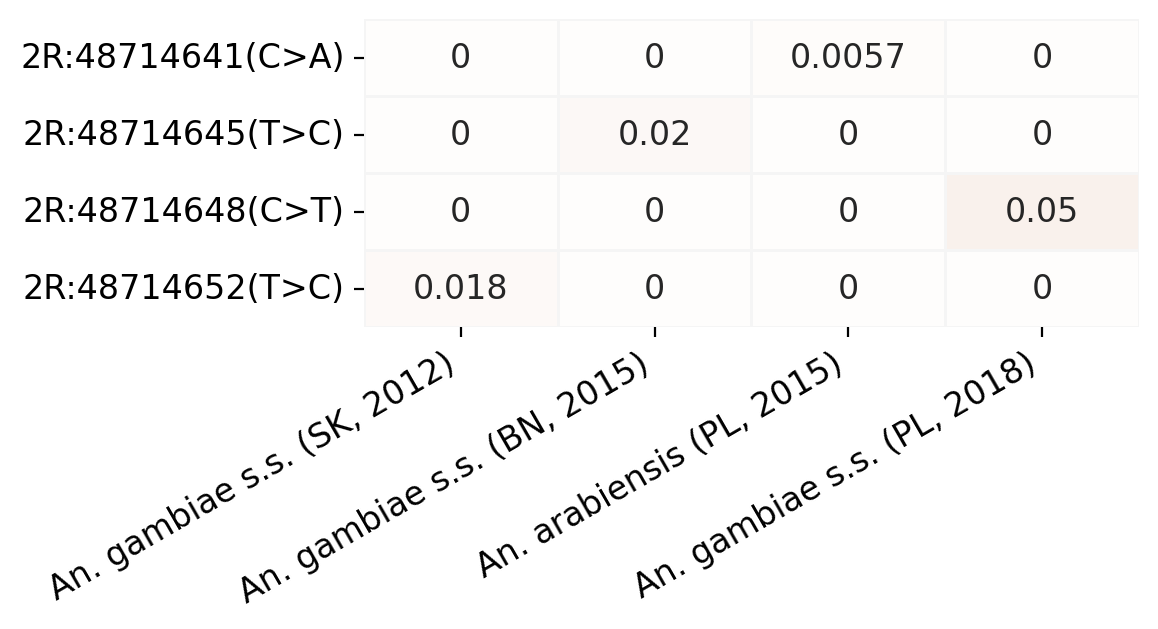

In [26]:
# plot allele freqs per pop
fig, ax = plt.subplots(figsize=(5,2))
petl_gdy = petl.fromdataframe(freq_year_gd)

labels = ['2R:%s(%s>%s)' % (rec.position, rec.ref_allele, rec.alt_allele) for rec in petl_gdy.records()]
# plot
ax1=sns.heatmap(freq_year_gd[col_y_sel],vmin=0,vmax=1,cmap=color_2, yticklabels=labels,xticklabels=labs_sel,
                linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population within the AGAP004050 gene")
plt.xticks(rotation=30, ha='right')
plt.show()

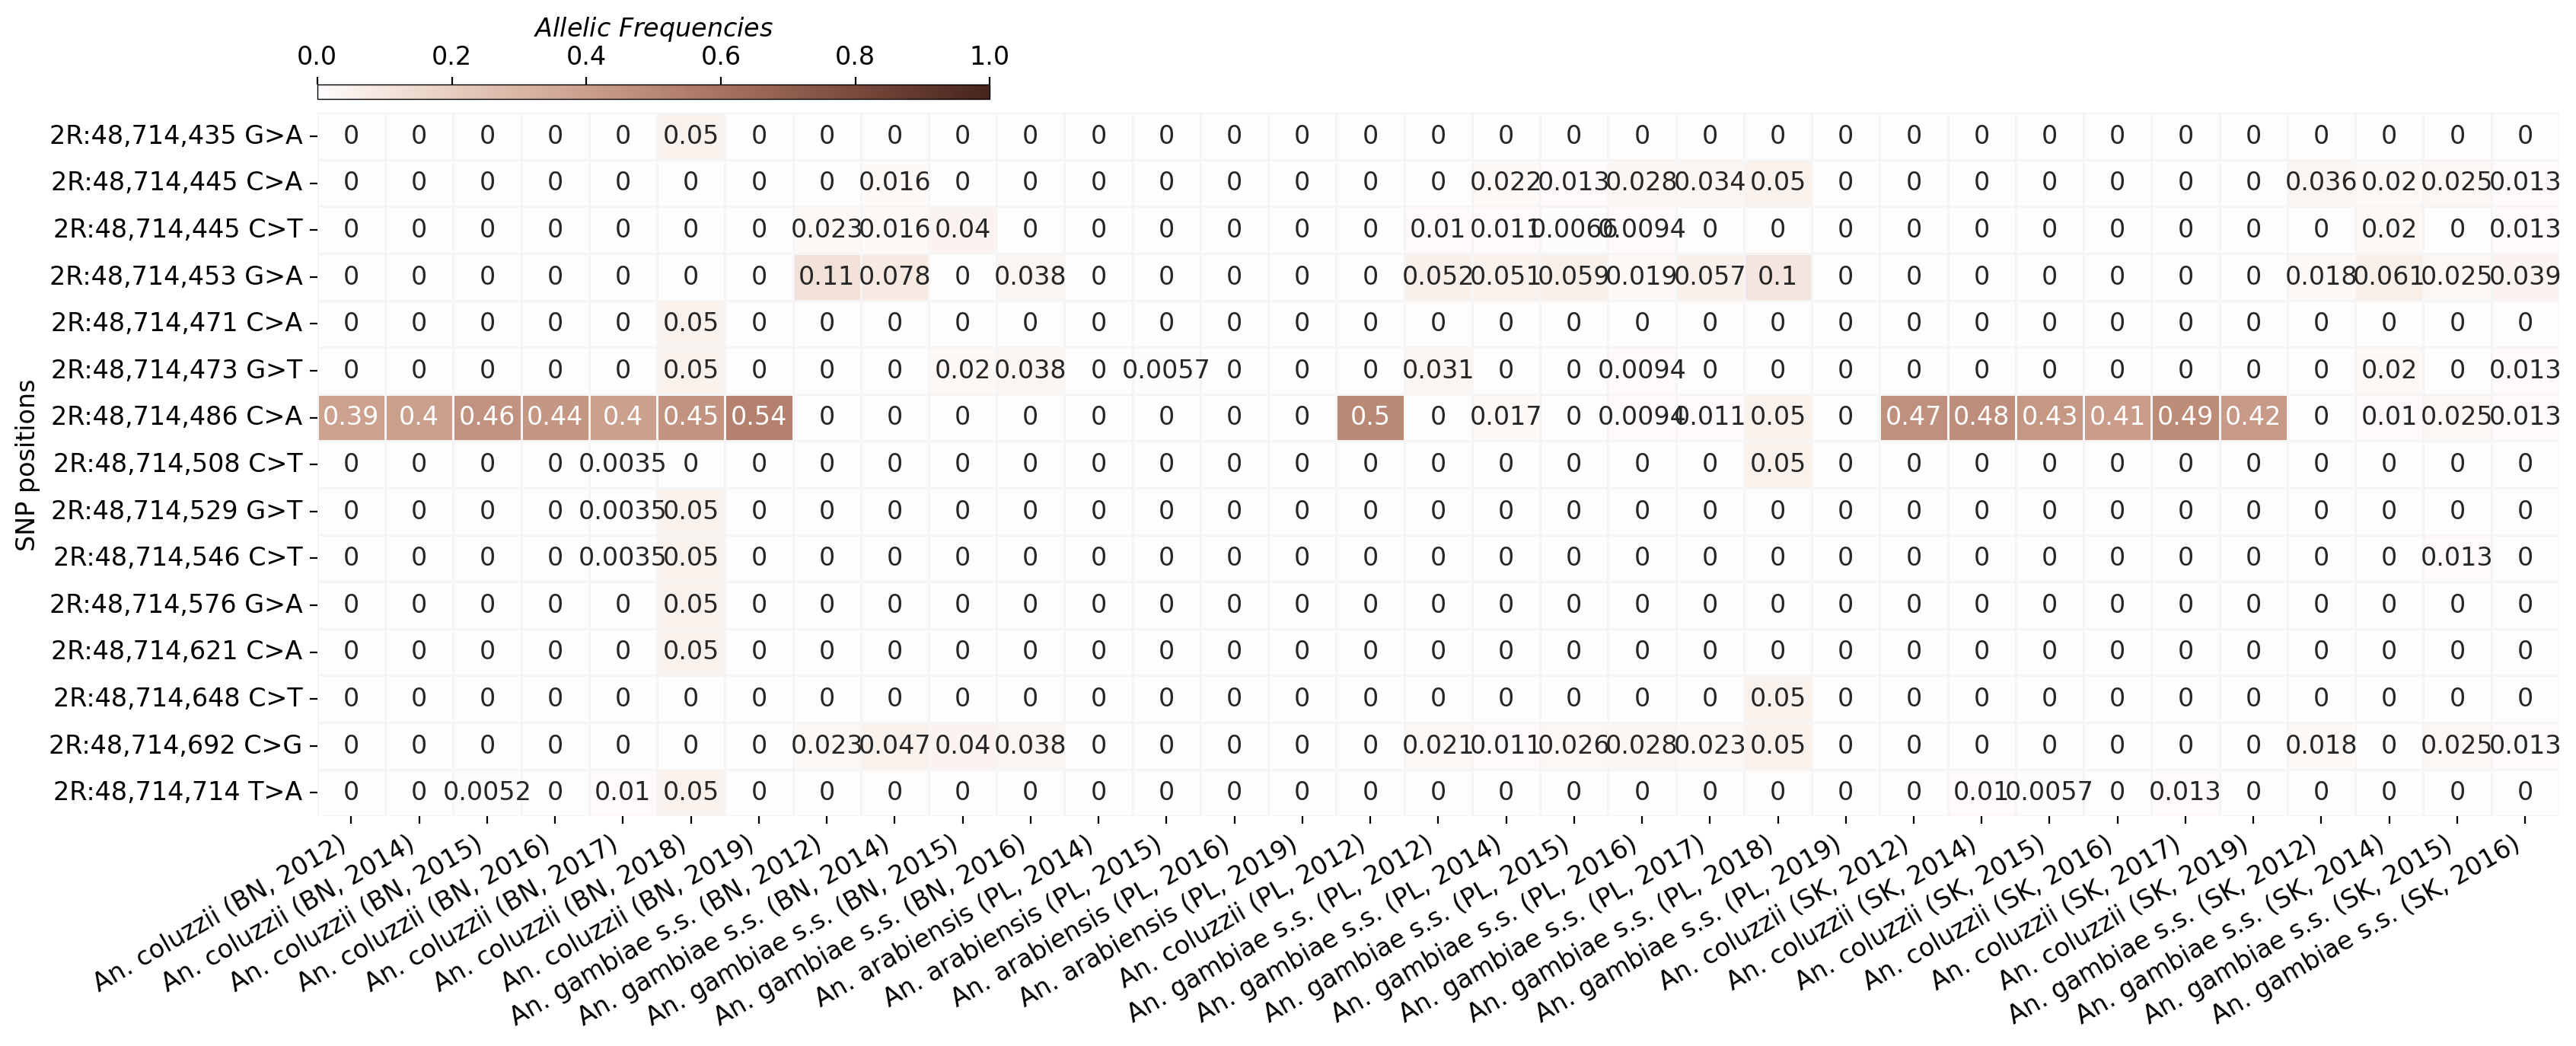

In [27]:
# plot allele freqs per pop in the region around the gene drive target site
fig, ax = plt.subplots(figsize=(19,6))
frq_tab1 = freq_year_arr.query('max_af>0.04')
petl_arr = petl.fromdataframe(frq_tab1)

labels = ['2R:%s(%s>%s)' % (rec.position, rec.ref_allele, rec.alt_allele) for rec in petl_arr.records()]
# plot
ax=sns.heatmap(frq_tab1[columns_y1],vmin=0,vmax=1,cmap=color_2, yticklabels=frq_tab1.label,xticklabels=labs_sel1,
                linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population within the AGAP004050 gene")
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('SNP positions')
cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allelic$ $Frequencies$')
#fig.tight_layout()
fig.savefig('graph/allelic_freq_y.png', dpi=300, bbox_inches='tight')


In [28]:
base_font_size = 12
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size

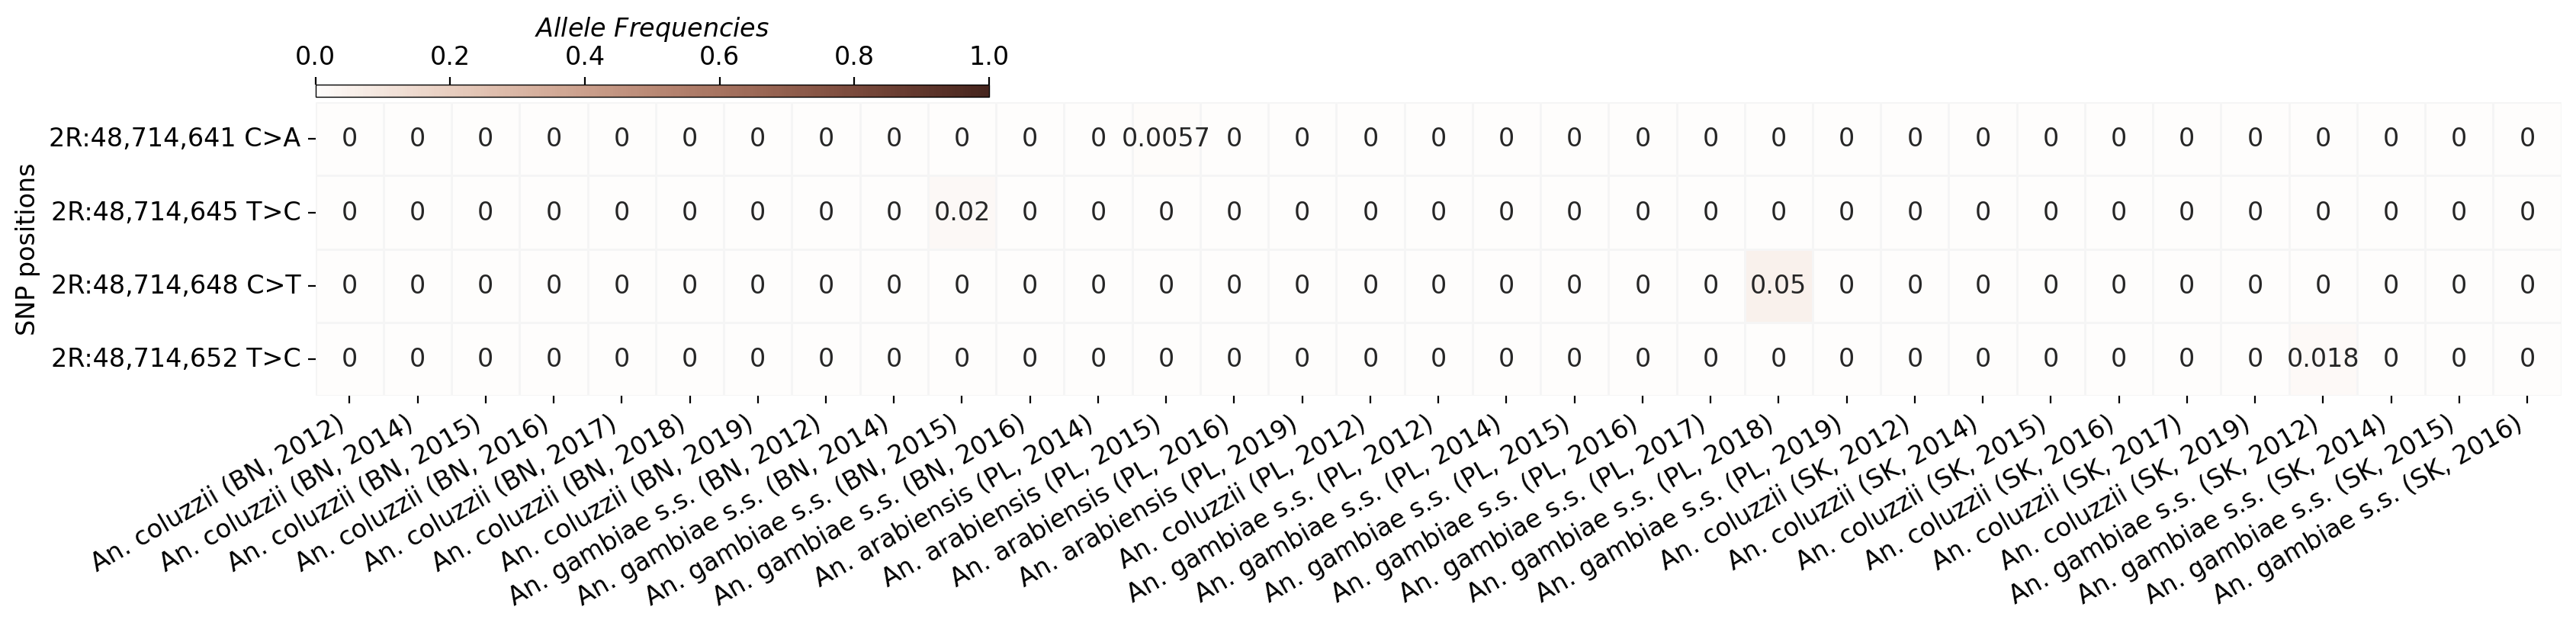

In [29]:
# plot allele freqs per pop in the region around the gene drive target site
fig, ax = plt.subplots(figsize=(19,2.5))
frq_tab1 = freq_year_gd
petl_arr = petl.fromdataframe(frq_tab1)

labels = ['2R:%s(%s>%s)' % (rec.position, rec.ref_allele, rec.alt_allele) for rec in petl_arr.records()]
# plot
ax=sns.heatmap(frq_tab1[columns_y1],vmin=0,vmax=1,cmap=color_2, yticklabels=frq_tab1.label,xticklabels=labs_sel1,
                linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population within the AGAP004050 gene")
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('SNP positions')
cax = inset_axes(ax,width="30%", height="4%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allele$ $Frequencies$')
#fig.tight_layout()
fig.savefig('graph/allelic_freq_gd_y.png', dpi=300, bbox_inches='tight')


In [80]:
new_col_list = ['contig', 'position', 'ref_allele', 'alt_allele','transcript',
                'An. coluzzii (BN, 2012)', 'An. coluzzii (BN, 2014)', 'An. coluzzii (BN, 2015)', 'An. coluzzii (BN, 2016)',
                'An. coluzzii (BN, 2017)', 'An. coluzzii (BN, 2018)', 'An. coluzzii (BN, 2019)',
                'An. gambiae s.s. (BN, 2012)', 'An. gambiae s.s. (BN, 2014)', 'An. gambiae s.s. (BN, 2015)', 
                'An. gambiae s.s. (BN, 2016)',
                'An. arabiensis (PL, 2014)', 'An. arabiensis (PL, 2015)', 'An. arabiensis (PL, 2016)', 'An. arabiensis (PL, 2019)',
                'An. coluzzii (PL, 2012)', 
                'An. gambiae s.s. (PL, 2012)', 'An. gambiae s.s. (PL, 2014)', 'An. gambiae s.s. (PL, 2015)', 
                'An. gambiae s.s. (PL, 2016)',
                'An. gambiae s.s. (PL, 2017)', 'An. gambiae s.s. (PL, 2018)', 'An. gambiae s.s. (PL, 2019)',
                'An. coluzzii (SK, 2012)', 'An. coluzzii (SK, 2014)', 'An. coluzzii (SK, 2015)', 'An. coluzzii (SK, 2016)',
                'An. coluzzii (SK, 2017)', 'An. coluzzii (SK, 2019)',
                'An. gambiae s.s. (SK, 2012)', 'An. gambiae s.s. (SK, 2014)', 'An. gambiae s.s. (SK, 2015)', 
                'An. gambiae s.s. (SK, 2016)','max_af'
               ]

col_list1 = ['contig', 'position', 'ref_allele', 'alt_allele', 'transcript',
             'frq_Bana_col_2012', 'frq_Bana_col_2014', 'frq_Bana_col_2015', 'frq_Bana_col_2016', 'frq_Bana_col_2017', 
             'frq_Bana_col_2018','frq_Bana_col_2019', 'frq_Bana_gam_2012', 'frq_Bana_gam_2014', 'frq_Bana_gam_2015', 
             'frq_Bana_gam_2016', 'frq_Pala_ara_2014', 'frq_Pala_ara_2015', 'frq_Pala_ara_2016',
             'frq_Pala_ara_2019', 'frq_Pala_col_2012', 'frq_Pala_gam_2012', 'frq_Pala_gam_2014', 'frq_Pala_gam_2015', 
             'frq_Pala_gam_2016', 'frq_Pala_gam_2017', 'frq_Pala_gam_2018', 'frq_Sour_ara_2019', 'frq_Sour_col_2012', 
             'frq_Sour_col_2014', 'frq_Sour_col_2015', 'frq_Sour_col_2016', 'frq_Sour_col_2017', 'frq_Sour_col_2019',
             'frq_Sour_gam_2012', 'frq_Sour_gam_2014', 'frq_Sour_gam_2015', 'frq_Sour_gam_2016','max_af']


In [90]:
Table_S2 = freq_year_arr[col_list1]
Table_S2.columns = new_col_list
Table_S2.to_csv('data_saved/Table_S2.csv')

In [88]:
freq_year_arr[col_list1].shape

(90, 39)

In [74]:
freq_year_gd.columns

Index(['contig', 'position', 'ref_allele', 'alt_allele', 'aa_change',
       'pass_gamb_colu_arab', 'pass_gamb_colu', 'pass_arab',
       'frq_Bana_col_2012', 'frq_Bana_col_2014', 'frq_Bana_col_2015',
       'frq_Bana_col_2016', 'frq_Bana_col_2017', 'frq_Bana_col_2018',
       'frq_Bana_col_2019', 'frq_Bana_gam_2012', 'frq_Bana_gam_2014',
       'frq_Bana_gam_2015', 'frq_Bana_gam_2016', 'frq_Mono_gam_2004',
       'frq_Pala_ara_2014', 'frq_Pala_ara_2015', 'frq_Pala_ara_2016',
       'frq_Pala_ara_2019', 'frq_Pala_col_2012', 'frq_Pala_gam_2012',
       'frq_Pala_gam_2014', 'frq_Pala_gam_2015', 'frq_Pala_gam_2016',
       'frq_Pala_gam_2017', 'frq_Pala_gam_2018', 'frq_Sour_ara_2019',
       'frq_Sour_col_2012', 'frq_Sour_col_2014', 'frq_Sour_col_2015',
       'frq_Sour_col_2016', 'frq_Sour_col_2017', 'frq_Sour_col_2019',
       'frq_Sour_gam_2012', 'frq_Sour_gam_2014', 'frq_Sour_gam_2015',
       'frq_Sour_gam_2016', 'max_af', 'transcript', 'effect', 'impact',
       'ref_codon', 'alt_co

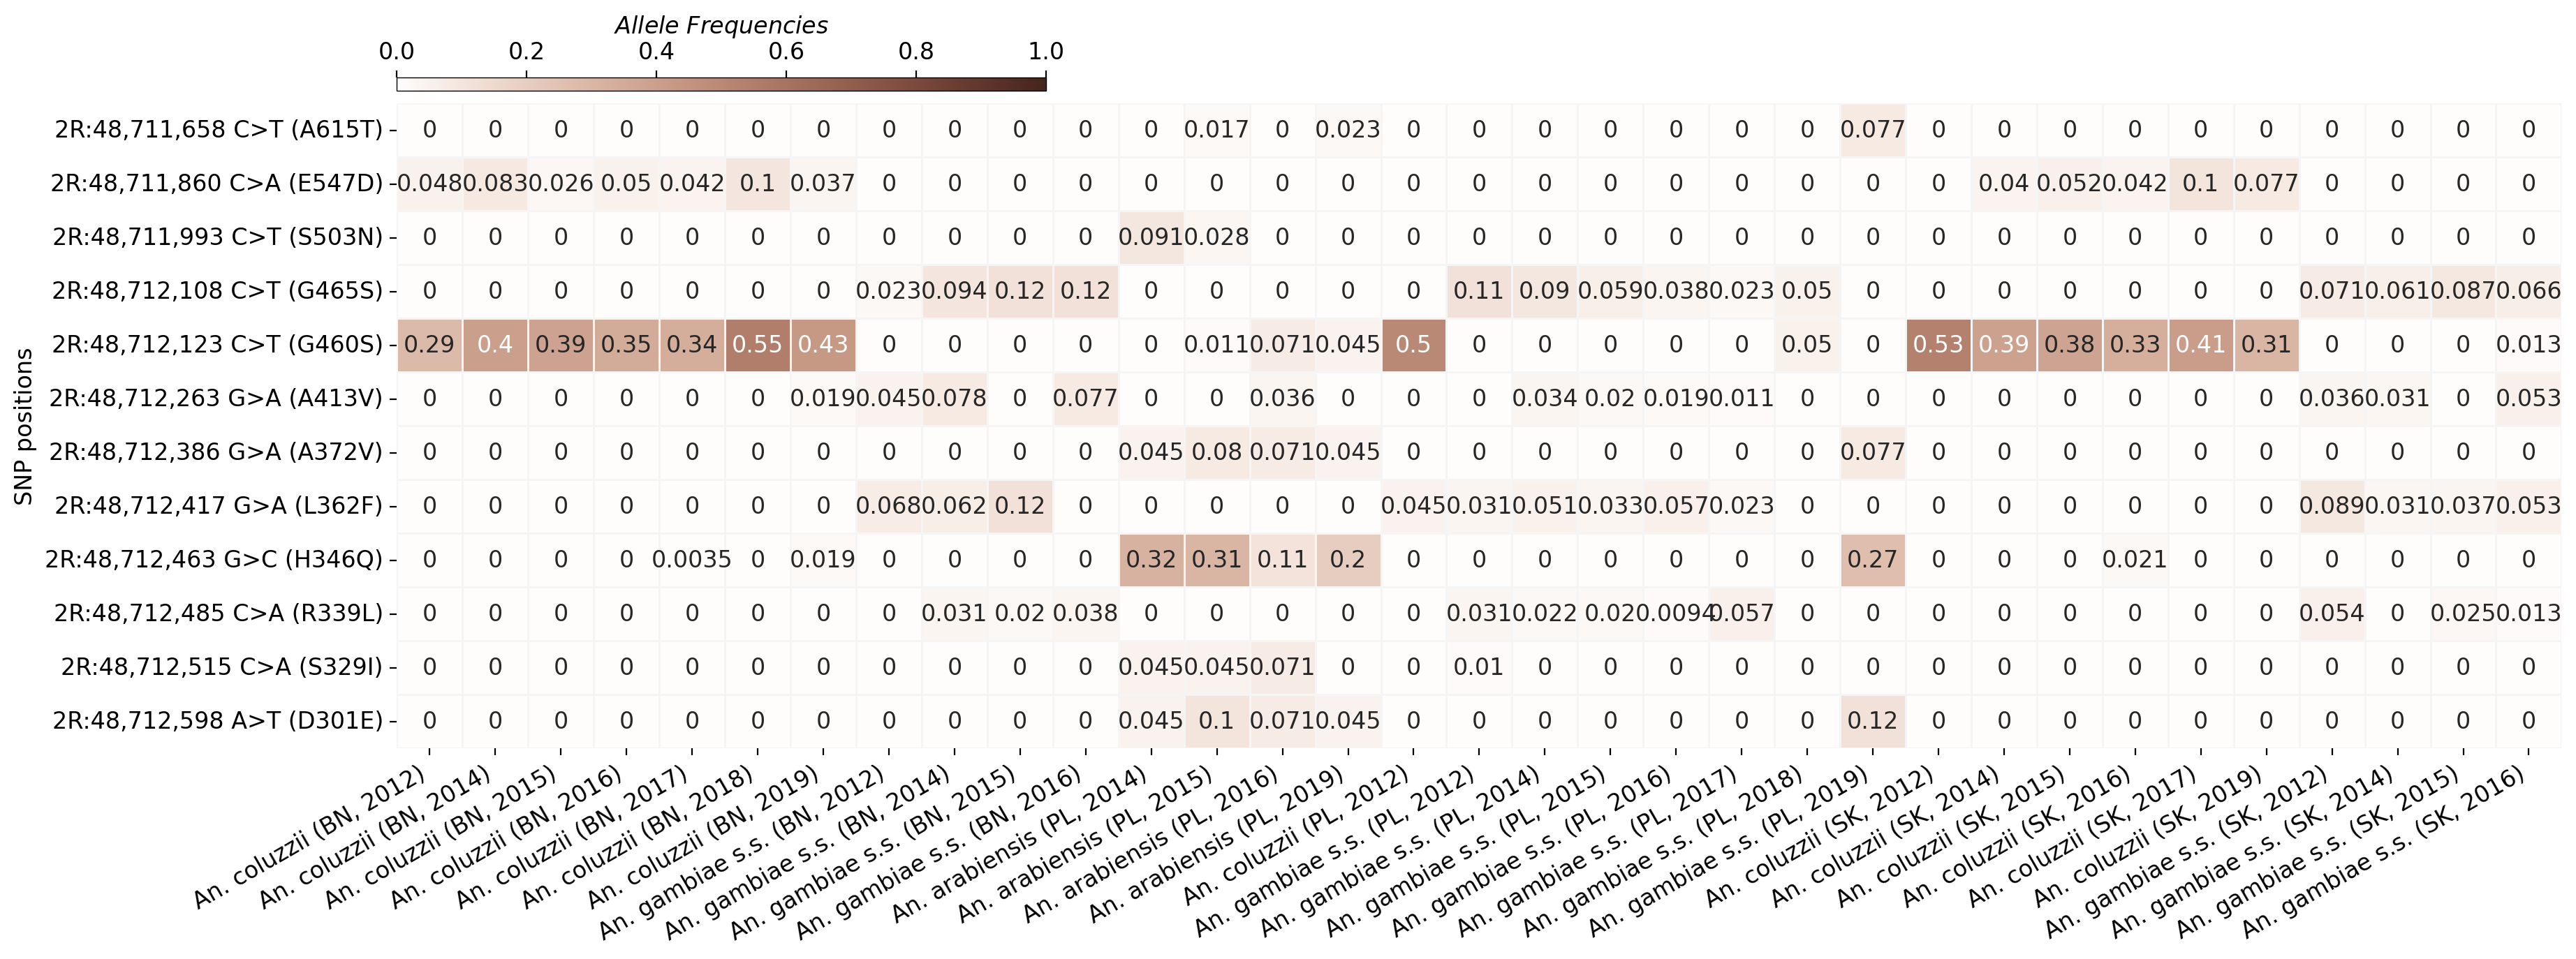

In [30]:
# plot allele freqs per pop in the region around the gene drive target site
fig, ax = plt.subplots(figsize=(20,6))
frq_tab2 = Ns_freq.query('max_af>0.05')
petl_arr = petl.fromdataframe(frq_tab2)

# plot
ax=sns.heatmap(frq_tab2[columns_y1],vmin=0,vmax=1,cmap=color_2, yticklabels=frq_tab2.label,xticklabels=labs_sel1,
                linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population within the AGAP004050 gene")
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('SNP positions')
cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allele$ $Frequencies$')
#fig.tight_layout()
fig.savefig('graph/allelic_Ns_freq_y.png', dpi=300, bbox_inches='tight')

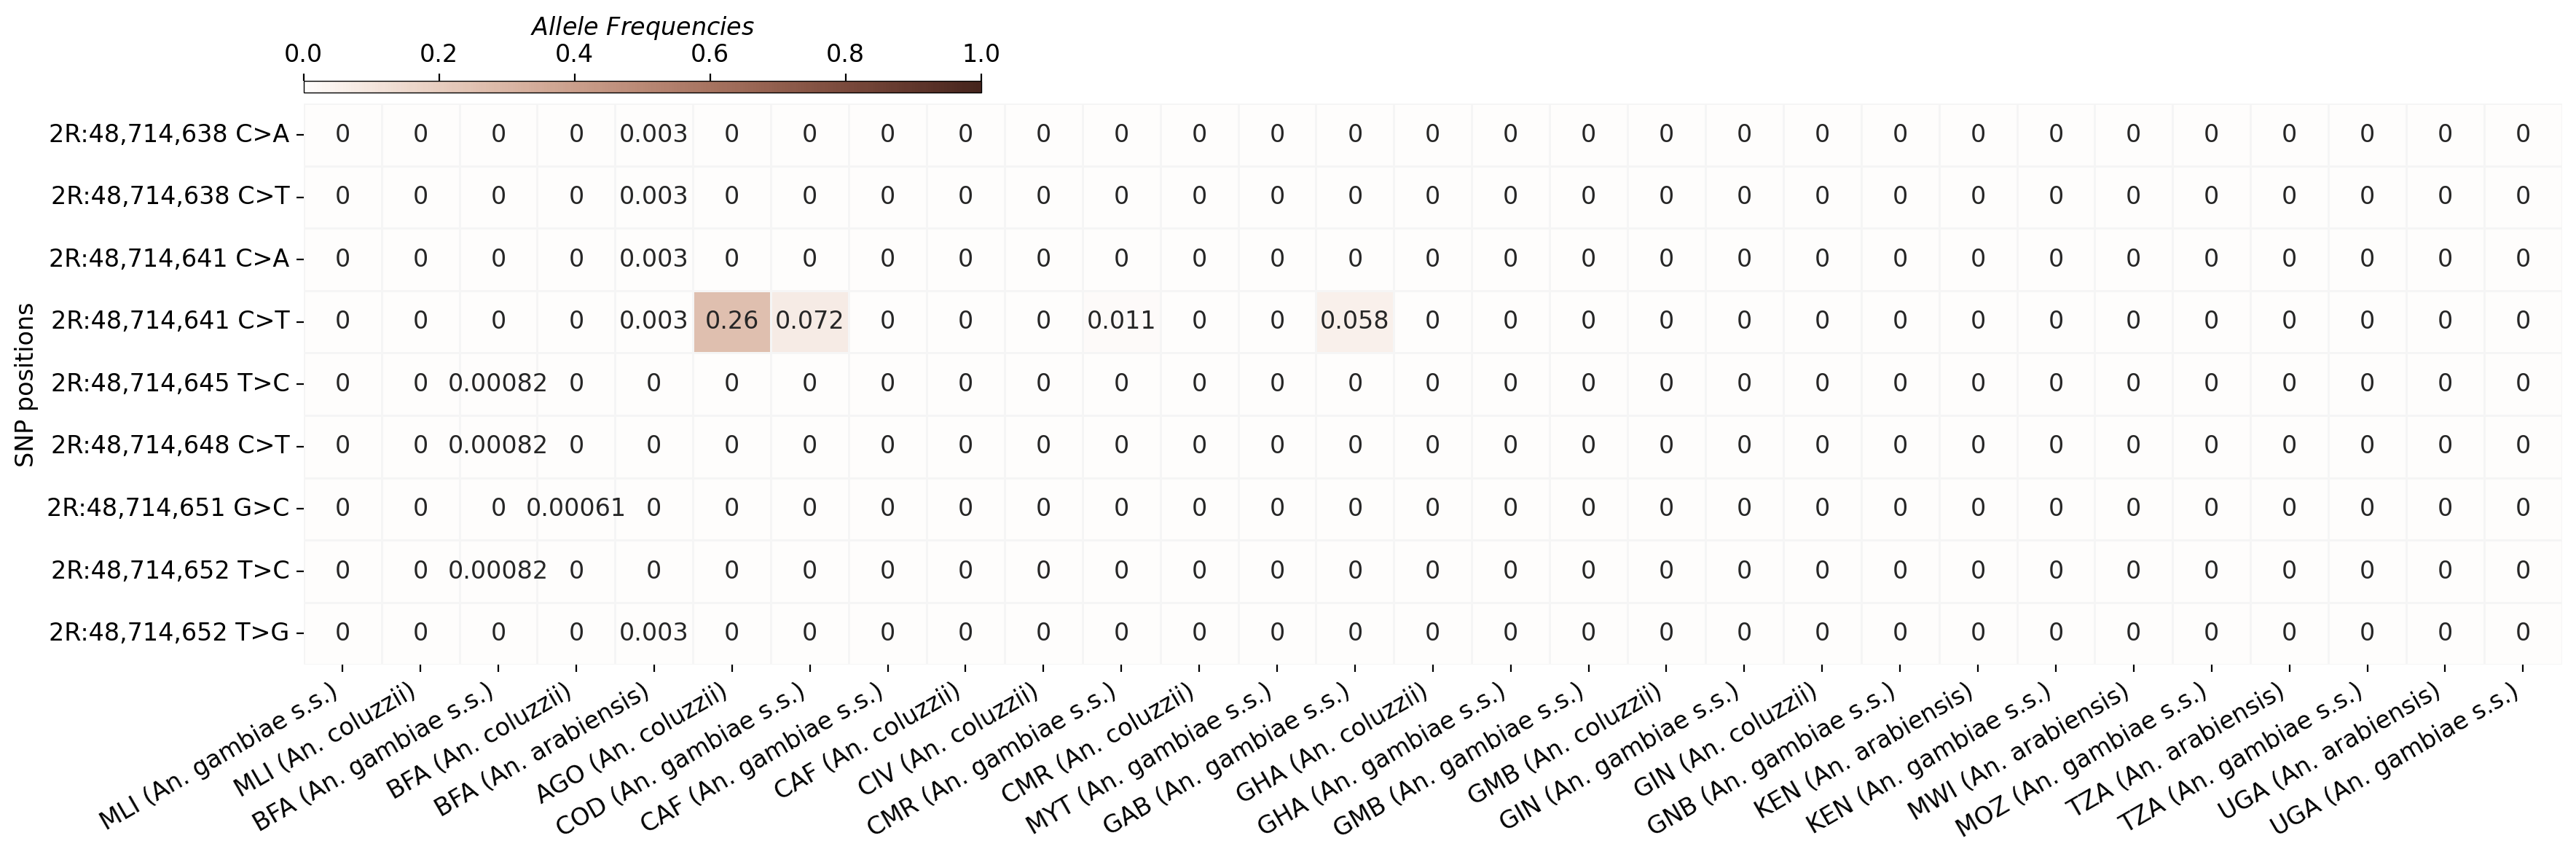

In [31]:
## rename col_name
col_name, col_list = {}, []
for col in freq_country_gd.columns:
    if col.split('_')[0]=='frq':
        col_list.append(col.split('frq_')[1])
        col_name[col] = col.split('frq_')[1]

freq_tab3 = freq_country_gd.rename(columns=col_name)

# plot allele freqs per pop in the region around the gene drive target site
fig, ax = plt.subplots(figsize=(20,5))

# plot
ax=sns.heatmap(freq_tab3[col_list],vmin=0,vmax=1,cmap=color_2, yticklabels=freq_country_gd.label,xticklabels=col_list,
                linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population within the AGAP004050 gene")
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('SNP positions')
cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allele$ $Frequencies$')
#fig.tight_layout()
fig.savefig('graph/allelic_freq_country_gd.png', dpi=300, bbox_inches='tight')


In [32]:
freq_tab4 = freq_tab3.copy().drop([6882,6883,6888,6890])
freq_tab4

,contig,position,ref_allele,alt_allele,aa_change,pass_gamb_colu_arab,pass_gamb_colu,pass_arab,MLI (An. gambiae s.s.),MLI (An. coluzzii),...,max_af,transcript,effect,impact,ref_codon,alt_codon,aa_pos,ref_aa,alt_aa,label
6884,2R,48714641,C,A,NaN,True,True,True,0.0,0.0,...,0.002994,AGAP004050-RA,INTRONIC,MODIFIER,NaN,NaN,NaN,NaN,NaN,"2R:48,714,641 C>A"
6885,2R,48714641,C,T,NaN,True,True,True,0.0,0.0,...,0.259259,AGAP004050-RA,INTRONIC,MODIFIER,NaN,NaN,NaN,NaN,NaN,"2R:48,714,641 C>T"
6886,2R,48714645,T,C,NaN,True,True,True,0.0,0.0,...,0.000820,AGAP004050-RA,INTRONIC,MODIFIER,NaN,NaN,NaN,NaN,NaN,"2R:48,714,645 T>C"
6887,2R,48714648,C,T,NaN,True,True,True,0.0,0.0,...,0.000820,AGAP004050-RA,INTRONIC,MODIFIER,NaN,NaN,NaN,NaN,NaN,"2R:48,714,648 C>T"
6889,2R,48714652,T,C,NaN,True,True,True,0.0,0.0,...,0.000820,AGAP004050-RA,INTRONIC,MODIFIER,NaN,NaN,NaN,NaN,NaN,"2R:48,714,652 T>C"


In [33]:
base_font_size = 12
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size

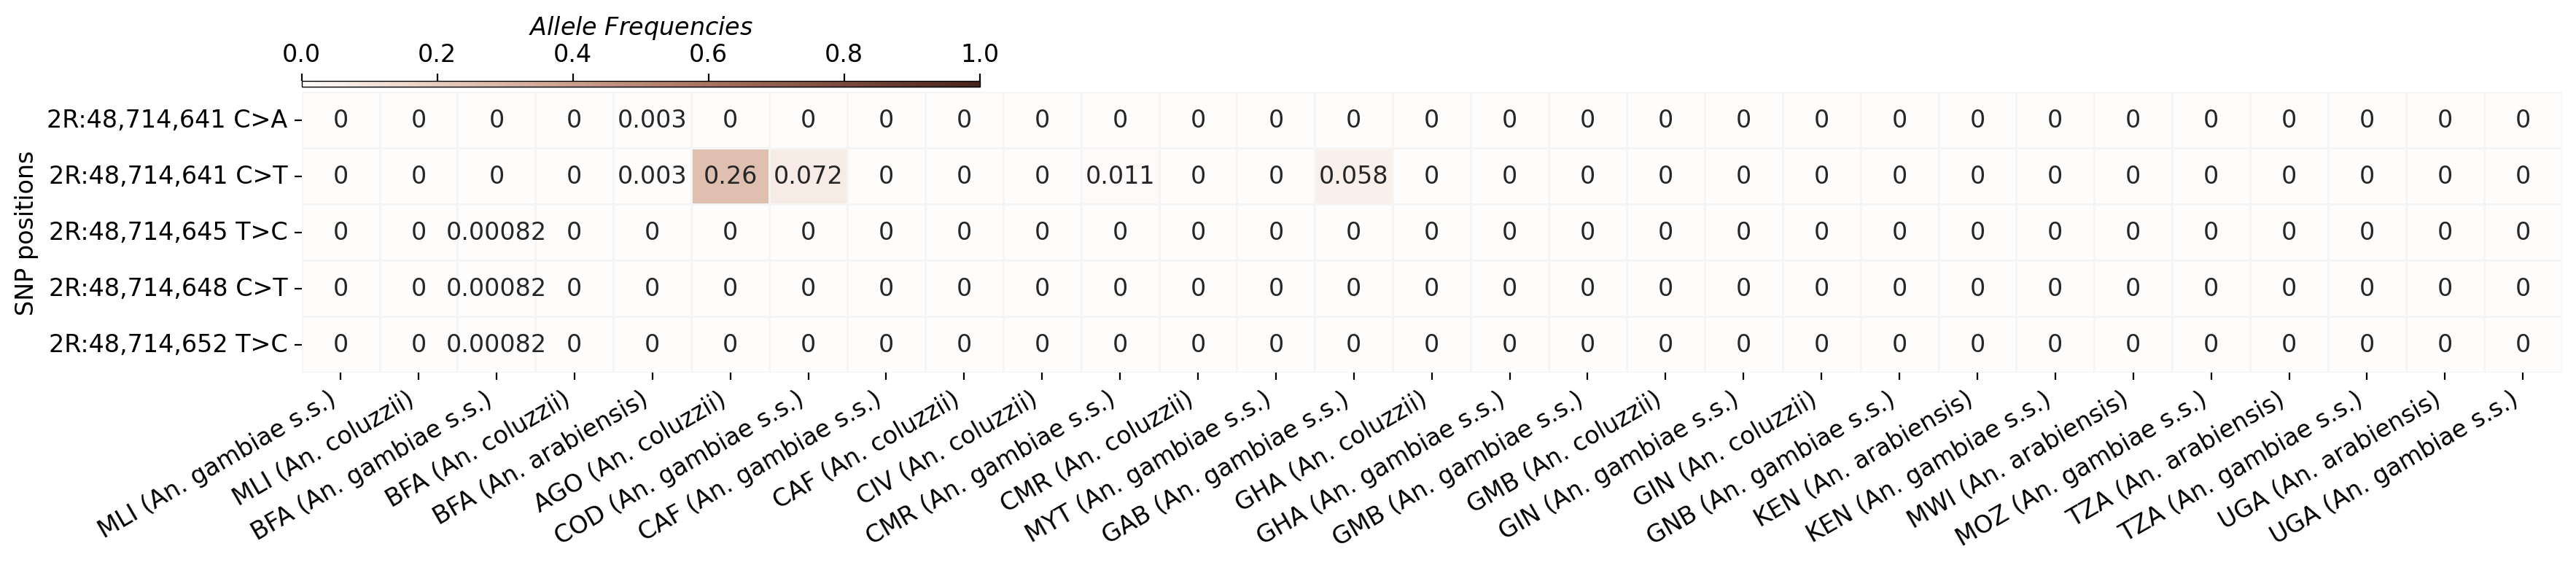

In [34]:
## rename col_name
col_name, col_list = {}, []
for col in freq_country_gd.columns:
    if col.split('_')[0]=='frq':
        col_list.append(col.split('frq_')[1])
        col_name[col] = col.split('frq_')[1]

#freq_tab3 = freq_country_gd.rename(columns=col_name)

# plot allele freqs per pop in the region around the gene drive target site
fig, ax = plt.subplots(figsize=(20,2.5))

# plot
ax=sns.heatmap(freq_tab4[col_list],vmin=0,vmax=1,cmap=color_2, yticklabels=freq_tab4.label,xticklabels=col_list,
                linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population within the AGAP004050 gene")
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('SNP positions')
cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allele$ $Frequencies$')
#fig.tight_layout()
fig.savefig('graph/allelic_freq_country_gd_12.png', dpi=300, bbox_inches='tight')

C:\Users\hp\AppData\Local\Temp\ipykernel_19236\1046785464.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


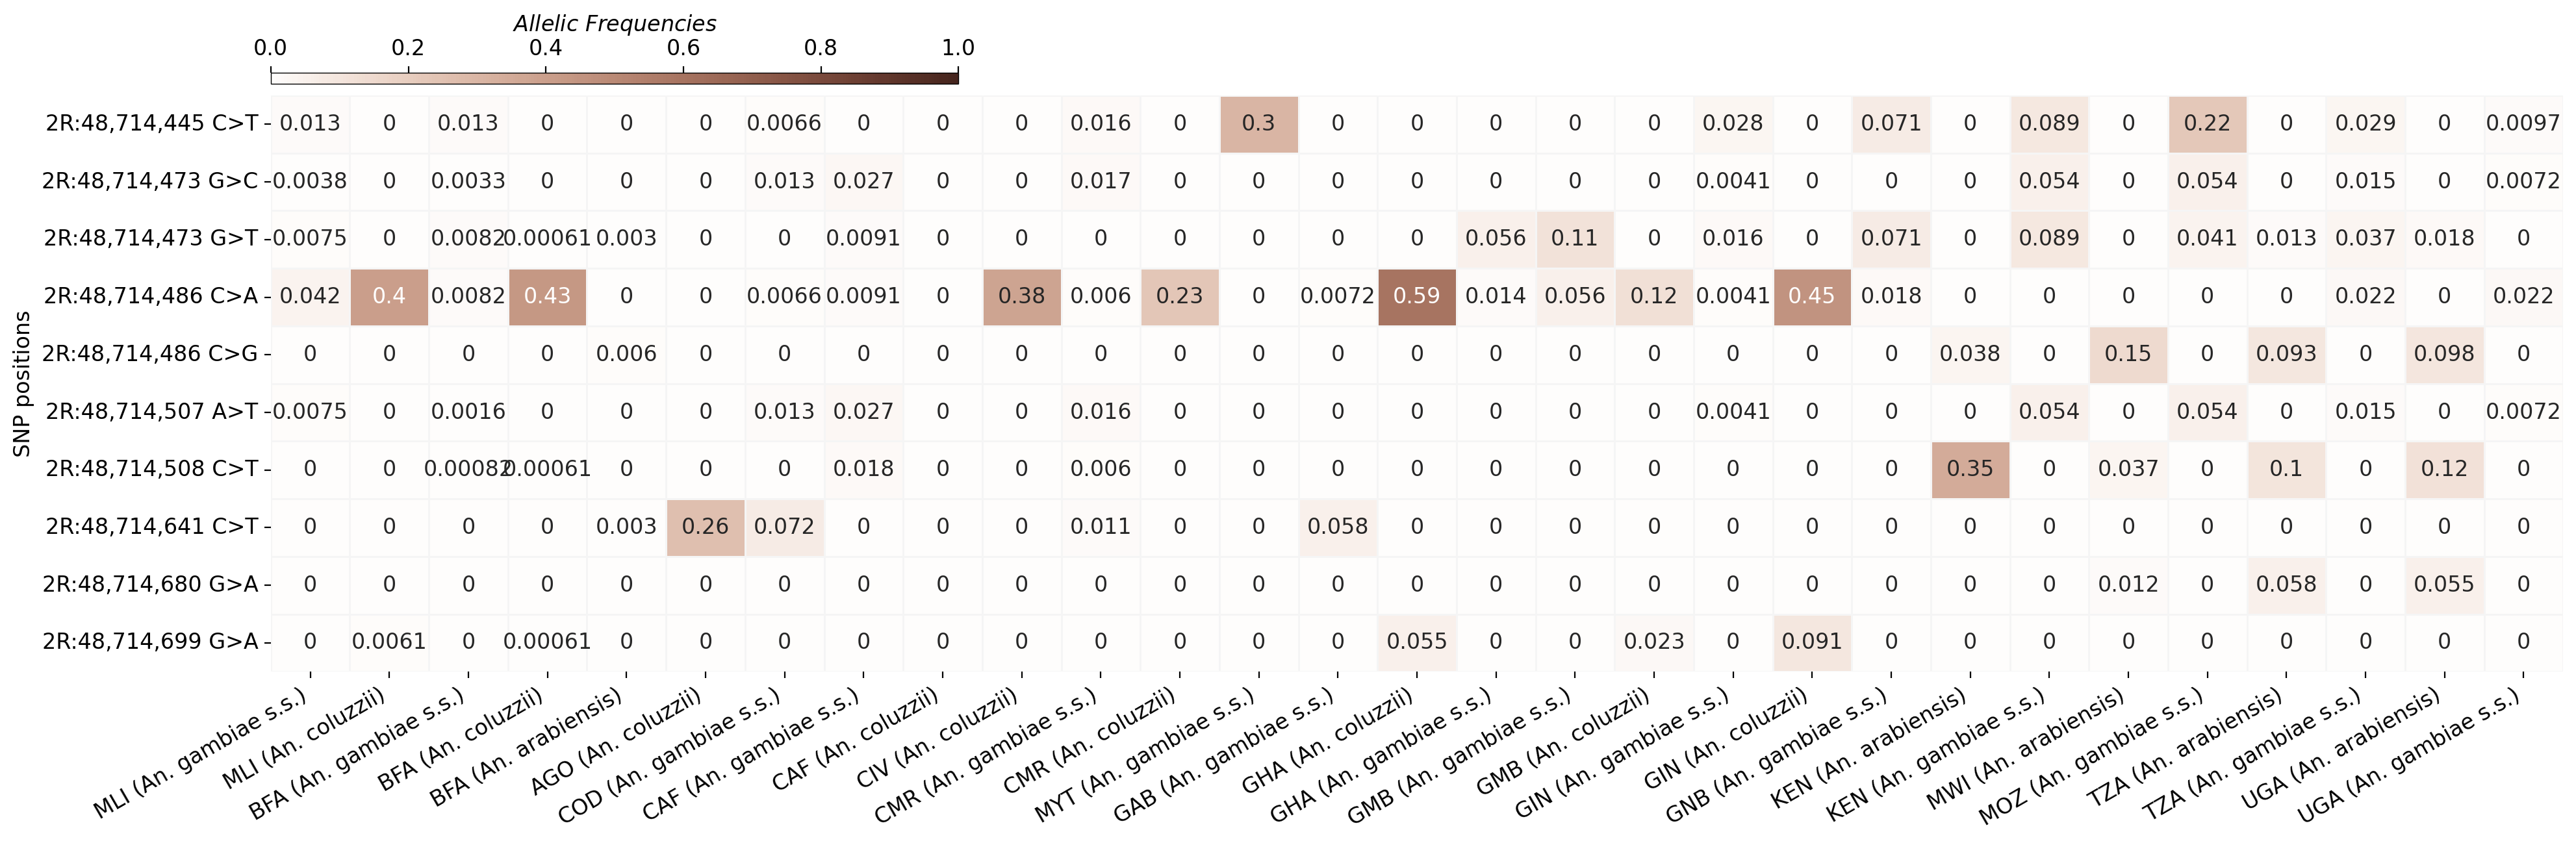

In [35]:
## rename col_name
freq_tb = freq_country_arr.query('max_af > 0.05')
col_name, col_list = {}, []
for col in freq_tb.columns:
    if col.split('_')[0]=='frq':
        col_list.append(col.split('frq_')[1])
        col_name[col] = col.split('frq_')[1]

freq_tab5 = freq_tb.rename(columns=col_name)

# plot allele freqs per pop in the region around the gene drive target site
fig, ax = plt.subplots(figsize=(20,6))

# plot
ax=sns.heatmap(freq_tab5[col_list],vmin=0,vmax=1,cmap=color_2, yticklabels=freq_tb.label,xticklabels=col_list,
                linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population within the AGAP004050 gene")
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('SNP positions')
cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allelic$ $Frequencies$')
fig.tight_layout()
fig.savefig('graph/allelic_freq_country_arr.png', dpi=300, bbox_inches='tight')
